In [137]:
from itertools import chain, repeat, islice
import pyaudio
import wave
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
from scipy.fftpack import ifft, idct

class Frame:
    '''
    The Frame class has the following properties:
    1. decoded: the decoded values (int64) of each frame
    2. processed: the values after pre-emphasis and hamming windowing
    3. energy: the log energy of each frame 
    4. speech: whether the frame is classified as speech or not
    5. speech_smoothed: whether the frame is classfied as speech or not after labele smoothing
    '''
    def __init__(self, decoded):
        decoded = np.array(decoded)
        self.decoded = decoded
        self.processed = self.process(decoded)
        self.energy = self._calc_energy()
        self.speech = 0
        self.speech_smoothed = 0
    def _calc_energy(self):
        sum = 0.
        for val in self.decoded: sum += float(val) ** 2
        energy = 0 if sum < 1 else (10 * np.log10(sum))
        return energy
    def process(self, decoded):
        pre_emphasis = 0.97
        processed = np.append(decoded[0], decoded[1:] - pre_emphasis * decoded[:-1])
        processed *= np.hamming(len(decoded))
        return processed

class Recorder:
    def __init__(
        self,
        channels=1,
        rate=16000, 
        frames_per_buffer=3200, 
        filename="recorded.wav", 
        endPo_settings={
        }):
        self.channels = channels
        self.rate = rate
        self.frames_per_buffer = frames_per_buffer
        self.frameSize = 320
        self.filename = filename
        self._pa = pyaudio.PyAudio()
        self._raw_audio = []
        self._frames = []
        self.filter_banks = []
        self.mfcc_list = []
        self.idct_mfcc = []
        self.endPo_settings = endPo_settings
        self.isRecording = False
        self._current_frame = 0
        self.accumulated_silence_frames = 0
        self.level = None
        self.background = None
        self.startFrame = int(self.endPo_settings['startTime'] * self.rate / self.frameSize * 2)
        self.stopFrame = int(self.endPo_settings['stopTime'] * self.rate / self.frameSize * 2)
        self.nfilt = int(self.endPo_settings['nfilt'])

    def _get_callback(self):
        def default_callback(in_data, frame_count, time_info, status):
            if self.isRecording:
                '''
                Save the original raw_audio data to the list.
                '''
                self._raw_audio.append(in_data)
                decoded = np.frombuffer(in_data, dtype=np.int16)
                FRAME_SIZE = self.frameSize
                cur_sample = 0
                '''
                Frame the decoded data to multiple frames, and append each frame to the _frames list.
                '''
                if len(self._frames) != 0:
                    tmp = []
                    tmp.extend(self._frames[-1].decoded[-FRAME_SIZE // 2:])
                    tmp.extend(decoded[:FRAME_SIZE // 2])
                    self._frames.append(Frame(tmp))
                while cur_sample < frame_count - FRAME_SIZE // 2:
                    self._frames.append(Frame(decoded[cur_sample: cur_sample + FRAME_SIZE]))
                    cur_sample += FRAME_SIZE // 2
                return (None, pyaudio.paContinue)
            else:
                return (None, pyaudio.paComplete)
        return default_callback

    def classify_speech(self, frame: Frame, mode: str, last_speech_status: int = 0):
        if mode == 'adaptive':
            forgetFactor = self.endPo_settings["forgetFactor"]
            adjustment = self.endPo_settings["adjustment"]
            threshold = self.endPo_settings["threshold"]
            
            current = frame.energy
            isSpeech = 0
            self.level = ((self.level * forgetFactor) + current) / (forgetFactor + 1)
            if (current < self.background):
                self.background = current
            else:
                self.background += (current - self.background) * adjustment
            if (self.level < self.background):
                self.level = self.background
            if (self.level - self.background) > threshold:
                isSpeech = 1
            frame.speech = isSpeech
            frame.speech_smoothed = isSpeech
            return isSpeech
        elif mode == 'onset':
            dynamicRange = self.endPo_settings["dynamicRange"]
            alpha = self.endPo_settings["alpha"]
            trackingFactor = self.endPo_settings["trackingFactor"]
            
            energy = frame.energy
            onsetThreshold = self.endPo_settings['onsetThreshold']
            offsetThreshold = onsetThreshold - dynamicRange
            isSpeech = last_speech_status
            if bool(isSpeech) and (energy - self.background) < offsetThreshold:
                isSpeech = 0
            elif (energy - self.background) > onsetThreshold:
                isSpeech = 1  
            if bool(isSpeech):
                self.background += (energy - self.background) * trackingFactor
            else:
                self.background = alpha * self.background + (1 - alpha) * energy
            frame.speech = isSpeech
            frame.speech_smoothed = isSpeech
            return isSpeech

    def calculate_mfcc(self, frame: Frame):
        nfilt = self.endPo_settings["nfilt"]
        
        '''
        Fast Fourier-Transform
        It is difficult to see the changing of the signal on time domain, so we use FFT to coverted into frequency domian to capture the changing.
        Different energy distributino on frequency domain represet different characteristics of different speech.
        '''

        # set N to 512
        NFFT = 512
        m_frames = np.absolute(np.fft.rfft(frame.processed, NFFT))
        
        # Power Spectrum
        p_frames = ((1.0 / NFFT) * (m_frames ** 2))
        
        '''
        Mel frequency mimic the sensitivity of the human ear to frequency, 
        from which it can also be seen that the perception of the human ear to frequency F is logarithmic.
        '''
         # Convert Hz to Mel, within 0Hz and sample_rate/2 (8000Hz)
        low_mel = 0
        high_mel = (2595 * np.log10(1 + (self.rate / 2) / 700)) 
        
        # The Mel scale is equally spaced
        mel_points = np.linspace(low_mel, high_mel, nfilt + 2)  
        
        # Convert Mel to Hz
        hz_points = (700 * (10**(mel_points / 2595) - 1)) 
        bin = np.floor((NFFT + 1) * hz_points / self.rate)
        
        '''
        filter banks is applying triangular filters on a Mel-scale to the power spectrum to extract frequency bands.
        '''
        
        # Values of each mel filter at corresponding points of the spectrum
        fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
        for m in range(1, nfilt + 1):
            mel_small = int(bin[m - 1])  
            mel_center = int(bin[m])           
            mel_big = int(bin[m + 1])   

            for k in range(mel_small, mel_center):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(mel_center, mel_big):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        
        filter_banks = np.dot(p_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
        
        # dB energy
        filter_banks = 10 * np.log10(filter_banks)  
        '''
        The discrete cosine transform (DCT) is applied to remove the filter bank coefficients 
        and generate a compressed filter bank representation.
        The cepstrum coefficients 13 were retained and the rest were discarded
        '''

        #remained cepstrum coefficients
        num_ceps = 13
        single_mfcc = scipy.fftpack.dct(filter_banks, type=2, axis=0, norm='ortho')
        single_mfcc = single_mfcc[1 : (num_ceps + 1)]
        
        '''
        Since the higher cepstral coefficients proveds less discrimination for speech recognition 
        than the lower cepstral coefficients. The  sinusoidal lifter give less weight to higher cepstral 
        coefficients and hence, proved better recognition performance for clean speech.
        
        In brief, the high-frequency part will be de-emphasized and the noise will be weakened
        '''
        cep_lifter = 22
        ncoeff = single_mfcc.shape[0]
        n = np.arange(ncoeff)
        lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
        single_mfcc *= lift

        # Mean Normailize
        filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
        single_mfcc -= (np.mean(single_mfcc, axis=0) + 1e-8) 
        
        # zero padding
        def pad_infinite(iterable, padding=None):
            return chain(iterable, repeat(padding))
        
        def pad(iterable, size, padding=None):
            return islice(pad_infinite(iterable, padding), size)        
        single_mfcc_idct = list(pad(single_mfcc, 64, 0))
        
        # inverse dct of mfcc
        single_mfcc_idct = idct(single_mfcc_idct, norm='ortho')
              
        return single_mfcc, filter_banks, single_mfcc_idct

    def start(self):
        """
        Start recording.
        """
        input("Start recording? (Enter)")
        self.isRecording = True
        self._stream = self._pa.open(
            format=pyaudio.paInt16,
            channels=self.channels,
            rate=self.rate,
            input=True,
            frames_per_buffer=self.frames_per_buffer,
            stream_callback=self._get_callback(),
        )
        while self._stream.is_active():
            timeLength = len(self._raw_audio) * self.frames_per_buffer / self.rate
            if self._current_frame < len(self._frames): # If there are frames left
                if self._current_frame > self.startFrame: # If grater than the start frame we've set
                    if (self.level is None) or (self.background is None): # Set background and level
                        self.level = self._frames[self._current_frame].energy
                        self.background = np.average([self._frames[i].energy for i in range(self.startFrame, len(self._frames))])

                    ## Classify the speech label, and smooth it
                    last_speech_status = self._frames[self._current_frame - 1].speech_smoothed
                    pauseFrames = int(self.endPo_settings['pauseTime'] * self.rate / self.frameSize * 2)
                    last_few_speech_status = [x.speech_smoothed for x in self._frames[self._current_frame - pauseFrames: self._current_frame]]
                    isSpeech = self.classify_speech(self._frames[self._current_frame], self.endPo_settings['mode'], last_speech_status)

                    if (last_speech_status == 0) and (isSpeech == 0):
                        self.accumulated_silence_frames += 1
                    else:
                        self.accumulated_silence_frames = 0
                    if (last_speech_status == 0) and np.sum(last_few_speech_status) > 0:
                        for frame in self._frames[self._current_frame - pauseFrames: self._current_frame]:
                            frame.speech_smoothed = 1

                    # Calculate the MFCC
                    frame_mfcc, filter_banks, idct_mfcc= self.calculate_mfcc(self._frames[self._current_frame])
                    self.mfcc_list.append(frame_mfcc)
                    self.filter_banks.append(filter_banks)
                    self.idct_mfcc.append(idct_mfcc)

                # If greater than the end frame we expect, determine whether the speech is complete and stop recording
                if self._current_frame > self.stopFrame:
                    if self.accumulated_silence_frames > int(self.endPo_settings['silenceTime'] * self.rate / self.frameSize * 2):
                        self.isRecording = False

                self._current_frame += 1
        print("[INFO] Stop recording")
        self.save()
        self.plot()
        self.plot_spec()
        self.plot_ceps()
        self.plot_idct_ceps()
        return self
    
    def save(self):
        '''
        Save frames to the file.
        '''
        self._frames_data = np.array([frame.processed for frame in self._frames[self.startFrame:]] ).flatten()
        self._timeLength = len(self._frames_data) / float(self.rate) / 2
        wf = wave.open(self.filename, 'wb')
        wf.setnchannels(self.channels)
        wf.setsampwidth(self._pa.get_sample_size(pyaudio.paInt16))
        wf.setframerate(self.rate)
        wf.writeframes(b''.join(self._raw_audio))
        wf.close()
        return self

    def terminate(self):
        '''
        Manually terminate the Recorder. Close and terminate all related process.
        '''
        self._stream.close()
        self._pa.terminate()
        print("[INFO] Recorder terminated")
        return self

    def plot_spec(self):
        """
        Plot the spectrogram.
        """
        khz = self.rate / 2000
        nfilt = self.endPo_settings["nfilt"]
        plt.figure(figsize=(20, 5))
        filter_banks_transpose = np.reshape(self.filter_banks, (len(self.filter_banks), nfilt)).T
        plt.imshow(filter_banks_transpose, cmap=plt.cm.jet, origin='lower', aspect='auto', extent=[0, self._timeLength, 0, khz])
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (kHz)')
        plt.title('spectrogram')
        plt.tight_layout()
        plt.show()

    def plot_idct_ceps(self):
        """
        Plot the idct derived spectrogram.
        """
        khz = self.rate/2000
        plt.figure(figsize=(20, 5))
        idct_mfcc_transpose = np.reshape(self.idct_mfcc, (len(self.idct_mfcc), 64)).T
        plt.imshow(idct_mfcc_transpose, cmap=plt.cm.jet, origin='lower', aspect='auto',extent=[0, self._timeLength, 0, khz])
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (kHz)')
        plt.title('IDCT-derived logspectrum')
        plt.tight_layout()
        plt.show()
    
    def plot_ceps(self):
        """
        Plot the mfcc coefficients cepstrum.
        """
        plt.figure(figsize=(20, 5))
        mfcc_list_transpose = np.reshape(self.mfcc_list, (len(self.mfcc_list), 13)).T
        plt.imshow(mfcc_list_transpose, cmap=plt.cm.jet, origin='lower', aspect='auto',extent=[0, self._timeLength, 0, 13])
        plt.xlabel('Time (s)')
        plt.ylabel('MFCC')
        plt.title('MFCC Coefficients cepstrum')
        plt.tight_layout()
        plt.show()
        

    def plot(self):
        '''
        Plot the sound graph with raw_speechStatus in blue and smoothed_speechStatus in red.
        '''
        startFrame = self.startFrame
        data = self._frames_data
        duration = 1 / float(self.rate)
        t = np.arange(0, self._timeLength, duration / 2)
        fig, ax = plt.subplots(figsize=(30, 10))
        ax.plot(t, data)
        ax2 = ax.twinx()
        raw_speechStatus = [frame.speech for frame in self._frames[startFrame:]]
        raw_speechStatus = np.repeat(raw_speechStatus, self.frameSize)
        smoothed_speechStatus = [frame.speech_smoothed for frame in self._frames[startFrame:]]
        smoothed_speechStatus = np.repeat(smoothed_speechStatus, self.frameSize)
        ax2.plot(t, raw_speechStatus, 'b')
        ax2.plot(t, smoothed_speechStatus, 'r')
        fig.show()
        fig.savefig('wave.png')
        print("[INFO] Plot and Wave saved")
        return self

[INFO] Stop recording
[INFO] Plot and Wave saved


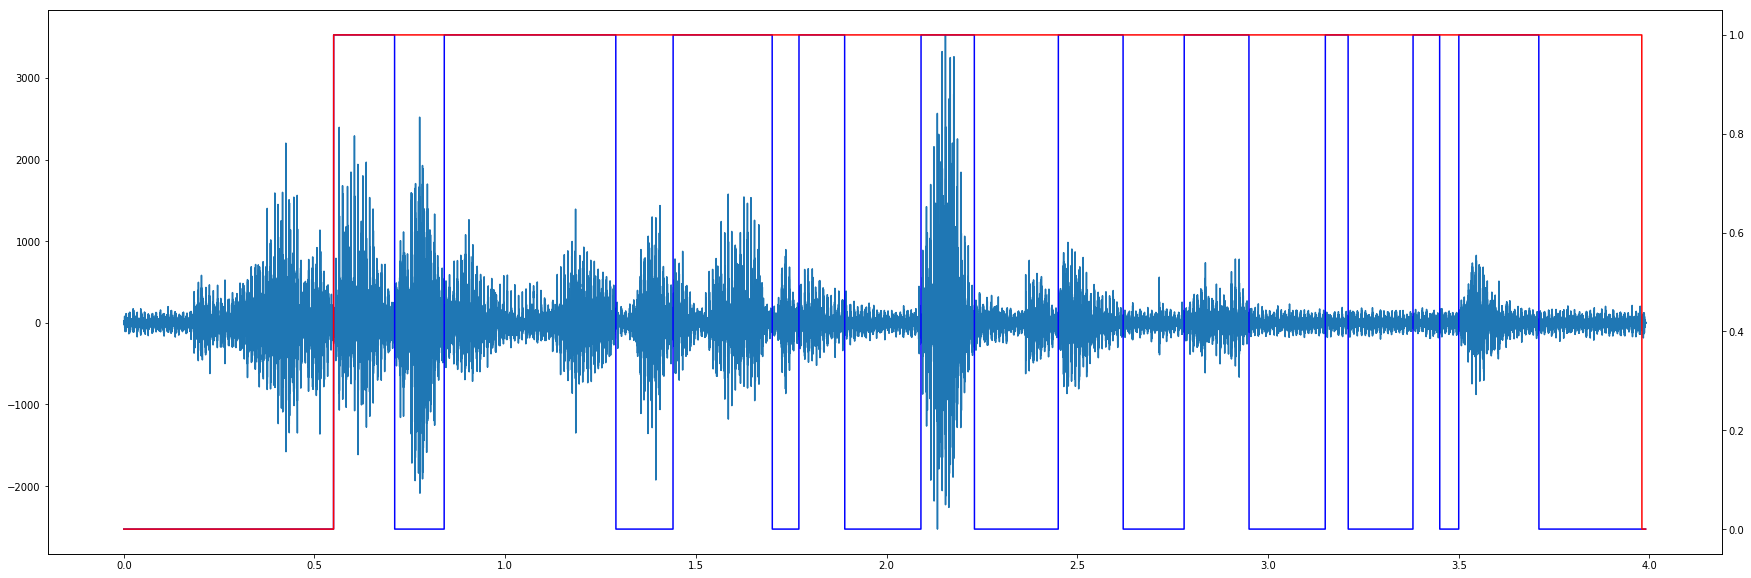

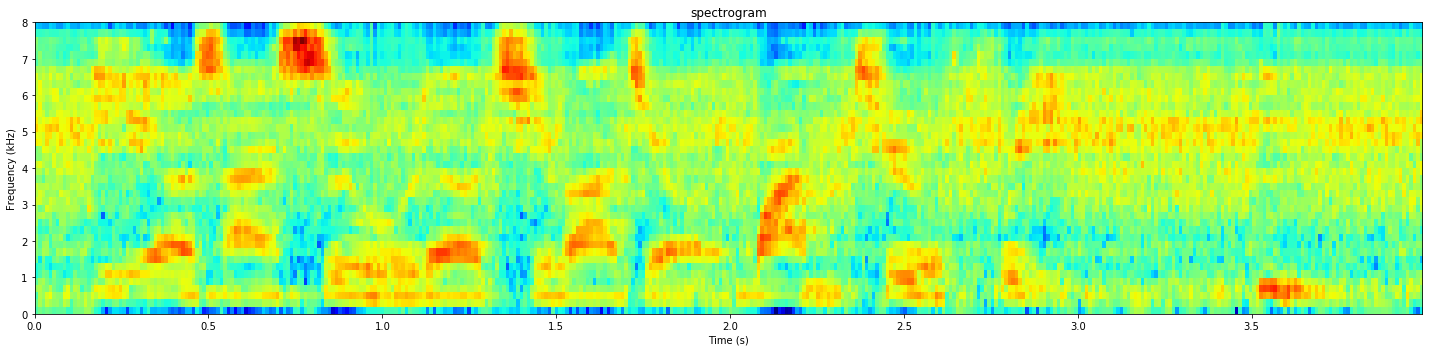

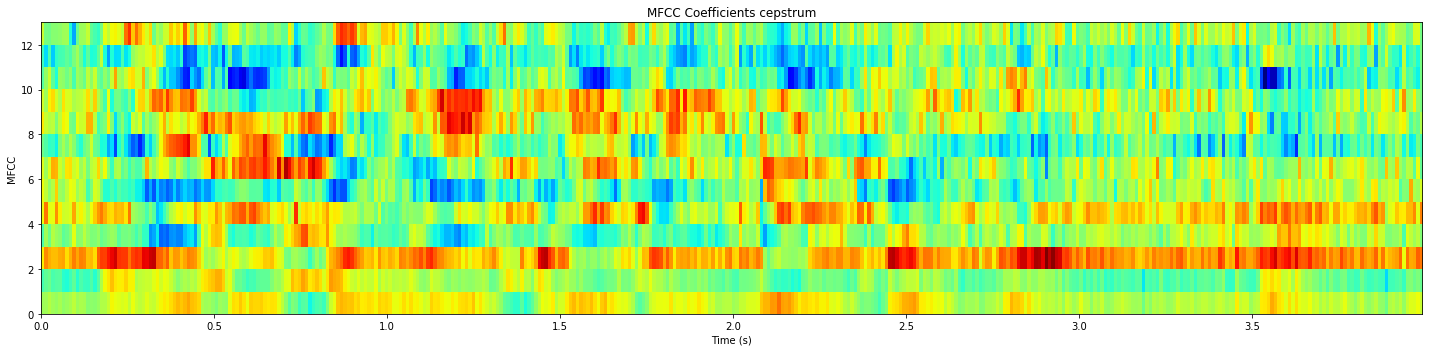

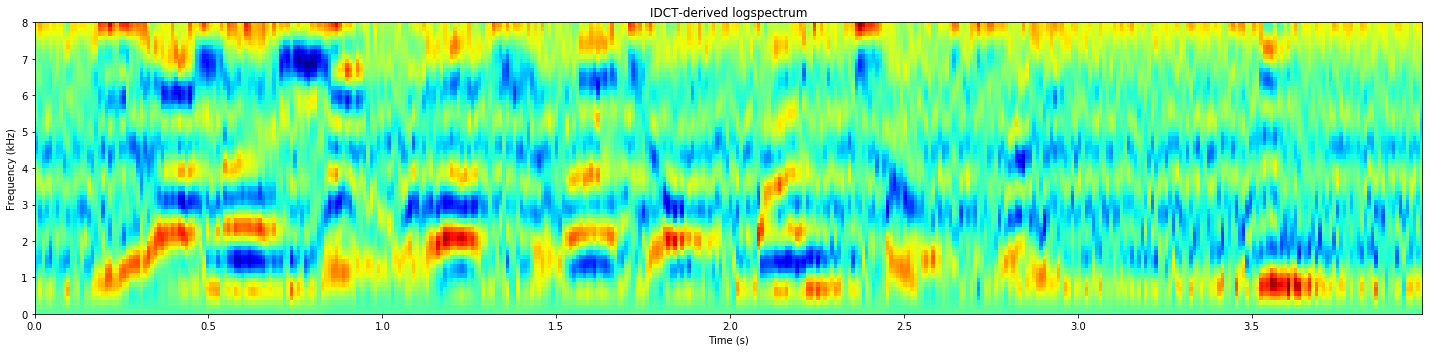

In [138]:
import time
# settings = {
#     "mode": "adaptive",
#     "startFrame": 5,
#     "stopFrame": 100,
#     "endingBoundary": 10,
#     "forgetFactor": 1,
#     "adjustment": 0.01,
#     "threshold": 10,
#     "smoothFrames": 5,
# }

settings = {
    "mode": "onset",
    "startTime": 0.2,
    "stopTime": 1,
    "silenceTime": 0.25,
    "pauseTime": 0.1,
    "nfilt": 40,
    "alpha": 0.4,
    "trackingFactor": 0.01,
    "onsetThreshold": 5,
    "dynamicRange": 3,
}
rec = Recorder(
    channels=1,
    rate=16000,
    frames_per_buffer=3200,
    filename="recorded.wav",
    endPo_settings=settings
)
rec.start()